# Пример обучения с учителем
# Классификация
## Предобработка

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report, 
                           roc_auc_score, roc_curve)
from sklearn.model_selection import cross_val_score

### Загружаем данные

Heart Disease UCI - данные о пациентах с риском сердечных заболеваний

Целевая переменная: target (0 = нет заболевания, 1 = есть заболевание)

**Признаки:**
1. age - возраст
2. sex - пол (1 = мужчина, 0 = женщина)
3. cp - тип боли в груди (0-3)
4. trestbps - давление в покое
5. chol - холестерин
6. fbs - сахар крови натощак > 120 мг/дл (1 = да, 0 = нет)
7. restecg - результаты ЭКГ в покое
8. thalach - максимальный пульс
9. exang - стенокардия при нагрузке (1 = да, 0 = нет)
10. oldpeak - депрессия ST сегмента
11. slope - наклон пика ST сегмента
12. ca - количество основных сосудов
13. thal - талассемия - наследственное заболевание крови (3 = норма, 6 = фиксированный дефект, 7 = обратимый дефект)

In [5]:
df = pd.read_csv("./heart.csv")
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Визуализация основных моментов

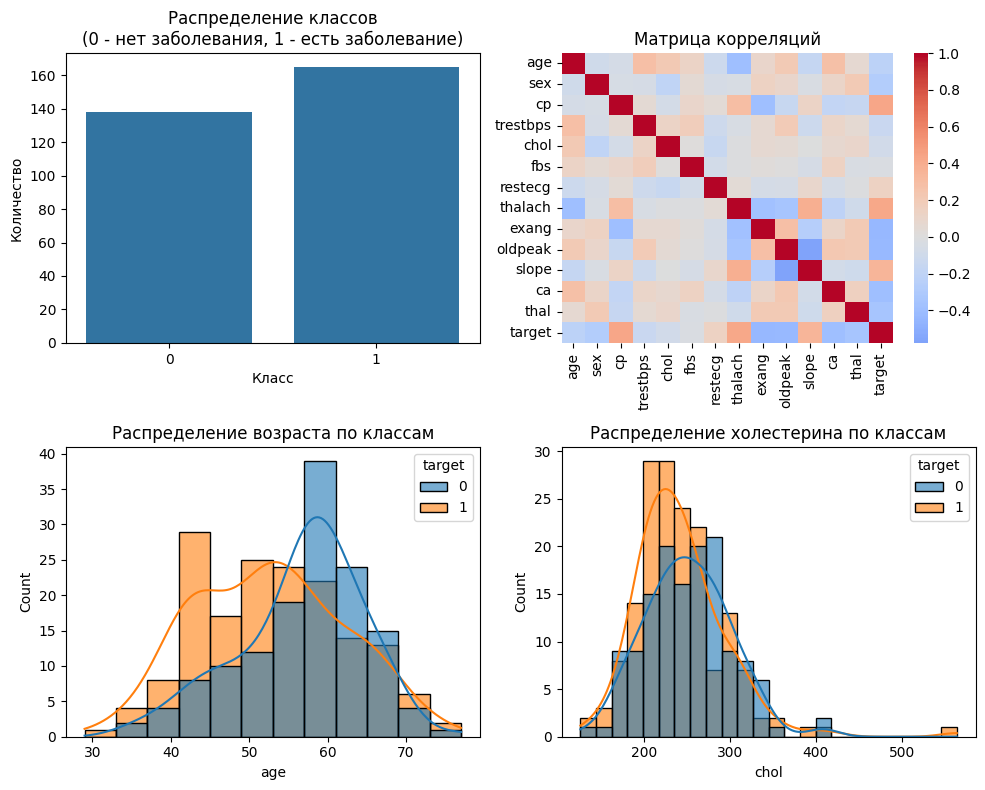

In [7]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.countplot(x='target', data=df)
plt.title('Распределение классов\n(0 - нет заболевания, 1 - есть заболевание)')
plt.xlabel('Класс')
plt.ylabel('Количество')

plt.subplot(2, 2, 2)
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Матрица корреляций')

plt.subplot(2, 2, 3)
sns.histplot(data=df, x='age', hue='target', kde=True, alpha=0.6)
plt.title('Распределение возраста по классам')

plt.subplot(2, 2, 4)
sns.histplot(data=df, x='chol', hue='target', kde=True, alpha=0.6)
plt.title('Распределение холестерина по классам')

plt.tight_layout()
plt.show()

### Определяем стобцы признаков и таргета

In [8]:
target_col = "target"
target_names = ["healthy", "sick"]
feature_col = df.columns.drop(target_col)
print("target column:", target_col)
print("target values:", target_names)
print("features columns:", feature_col)

X = df.drop('target', axis=1)
y = df['target']

print(f"Размерность данных: {X.shape}")
print(f"Количество классов: {len(np.unique(y))}")
print(f"Названия классов: {target_names}")
print(f"Количество признаков: {len(feature_col)}")

target column: target
target values: ['healthy', 'sick']
features columns: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')
Размерность данных: (303, 13)
Количество классов: 2
Названия классов: ['healthy', 'sick']
Количество признаков: 13


### Информация о данных

In [9]:
df['target_name'] = df['target'].map({0: 'malignant', 1: 'benign'})

print("Информация о данных:")
print(df.info())
print("\nСтатистика числовых признаков:")
print(df.describe())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    int64  
 1   sex          303 non-null    int64  
 2   cp           303 non-null    int64  
 3   trestbps     303 non-null    int64  
 4   chol         303 non-null    int64  
 5   fbs          303 non-null    int64  
 6   restecg      303 non-null    int64  
 7   thalach      303 non-null    int64  
 8   exang        303 non-null    int64  
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    int64  
 11  ca           303 non-null    int64  
 12  thal         303 non-null    int64  
 13  target       303 non-null    int64  
 14  target_name  303 non-null    object 
dtypes: float64(1), int64(13), object(1)
memory usage: 35.6+ KB
None

Статистика числовых признаков:
              age         sex          cp    trestbps      

### Делим на train и test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмер train: {X_train.shape}")
print(f"Размер test: {X_test.shape}")


Размер train: (242, 13)
Размер test: (61, 13)


### Нормализуем признаки

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Гребневый классификатор, Логистическая регрессия, SVM (линейный и нелинейный)

In [12]:
# Гребневый классификатор
rid_clf = RidgeClassifier(random_state=42, max_iter=1000)
rid_clf.fit(X_train_scaled, y_train)

# Логистическая регрессия
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# SVM с линейным ядром
svm_linear = SVC(kernel='linear', random_state=42, probability=True)
svm_linear.fit(X_train_scaled, y_train)

# SVM с RBF ядром (нелинейный)
svm_rbf = SVC(kernel='rbf', random_state=42, probability=True)
svm_rbf.fit(X_train_scaled, y_train)

# Naive Bayes с гауссовским распределением
gaus_nb = GaussianNB()
gaus_nb.fit(X_train_scaled, y_train)
print()

### Предсказываем метки и извлекаем вероятности, где можем

In [13]:
# Предсказания
y_pred_rid = rid_clf.predict(X_test_scaled)
y_pred_log = log_reg.predict(X_test_scaled)
y_pred_svm_linear = svm_linear.predict(X_test_scaled)
y_pred_svm_rbf = svm_rbf.predict(X_test_scaled)
y_pred_gaus_nb = gaus_nb.predict(X_test_scaled)

# Вероятности для ROC AUC
y_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]
y_proba_svm_linear = svm_linear.predict_proba(X_test_scaled)[:, 1]
y_proba_svm_rbf = svm_rbf.predict_proba(X_test_scaled)[:, 1]
y_proba_gaus_nb = gaus_nb.predict_proba(X_test_scaled)[:, 1]

### Оцениваем модели по разным метрикам
![](img/MetricsClass.png)

In [14]:
# Функция для вычисления метрик
def evaluate_model(y_true, y_pred, y_proba, model_name):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
        'ROC AUC': roc_auc_score(y_true, y_proba) if y_proba is not None else 0
    }
    
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    return metrics

# Оценка моделей
metrics_rid = evaluate_model(y_test, y_pred_rid, None, "Гребневый классификатор")
metrics_log = evaluate_model(y_test, y_pred_log, y_proba_log, "Логистическая регрессия")
metrics_svm_linear = evaluate_model(y_test, y_pred_svm_linear, y_proba_svm_linear, "SVM (линейное ядро)")
metrics_svm_rbf = evaluate_model(y_test, y_pred_svm_rbf, y_proba_svm_rbf, "SVM (RBF ядро)")
metrics_gaus_nb = evaluate_model(y_test, y_pred_gaus_nb, y_proba_gaus_nb, "Naive Bayes с гаусовским распределением")

# Сравнительная таблица метрик
comparison_df = pd.DataFrame({
    'Ridge Classifier': metrics_rid,
    'Logistic Regression': metrics_log,
    'SVM Linear': metrics_svm_linear,
    'SVM RBF': metrics_svm_rbf,
    'Naive Bayes': metrics_gaus_nb
})

print("\n" + "="*50)
print("Сравнительная таблица метрик:")
print(comparison_df)


Гребневый классификатор:
Accuracy: 0.7869
Precision: 0.7500
Recall: 0.9091
F1-Score: 0.8219
ROC AUC: 0.0000

Classification Report:
              precision    recall  f1-score   support

     healthy       0.86      0.64      0.73        28
        sick       0.75      0.91      0.82        33

    accuracy                           0.79        61
   macro avg       0.80      0.78      0.78        61
weighted avg       0.80      0.79      0.78        61


Логистическая регрессия:
Accuracy: 0.8033
Precision: 0.7692
Recall: 0.9091
F1-Score: 0.8333
ROC AUC: 0.8690

Classification Report:
              precision    recall  f1-score   support

     healthy       0.86      0.68      0.76        28
        sick       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61


SVM (линейное ядро):
Accuracy: 0.7869
Precision: 0.7500
Recall: 0.9091
F1-Score

### Визуализация ROC кривых

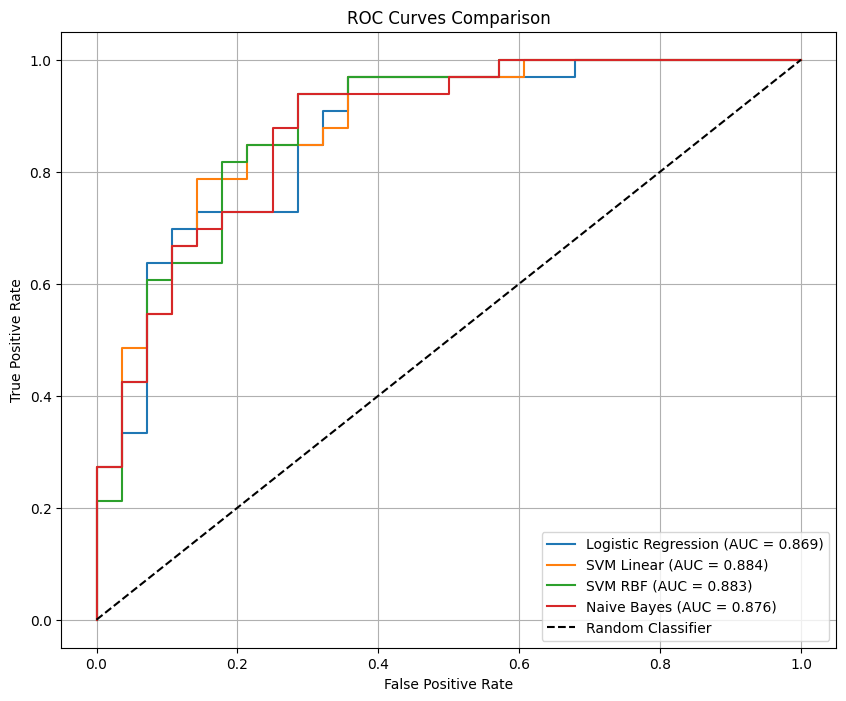

In [15]:
plt.figure(figsize=(10, 8))

fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
fpr_svm_linear, tpr_svm_linear, _ = roc_curve(y_test, y_proba_svm_linear)
fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, y_proba_svm_rbf)
fpr_gaus_nb, tpr_gaus_nb, _ = roc_curve(y_test, y_proba_gaus_nb)

plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {metrics_log["ROC AUC"]:.3f})')
plt.plot(fpr_svm_linear, tpr_svm_linear, label=f'SVM Linear (AUC = {metrics_svm_linear["ROC AUC"]:.3f})')
plt.plot(fpr_svm_rbf, tpr_svm_rbf, label=f'SVM RBF (AUC = {metrics_svm_rbf["ROC AUC"]:.3f})')
plt.plot(fpr_gaus_nb, tpr_gaus_nb, label=f'Naive Bayes (AUC = {metrics_gaus_nb["ROC AUC"]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

### Матрицы ошибок    

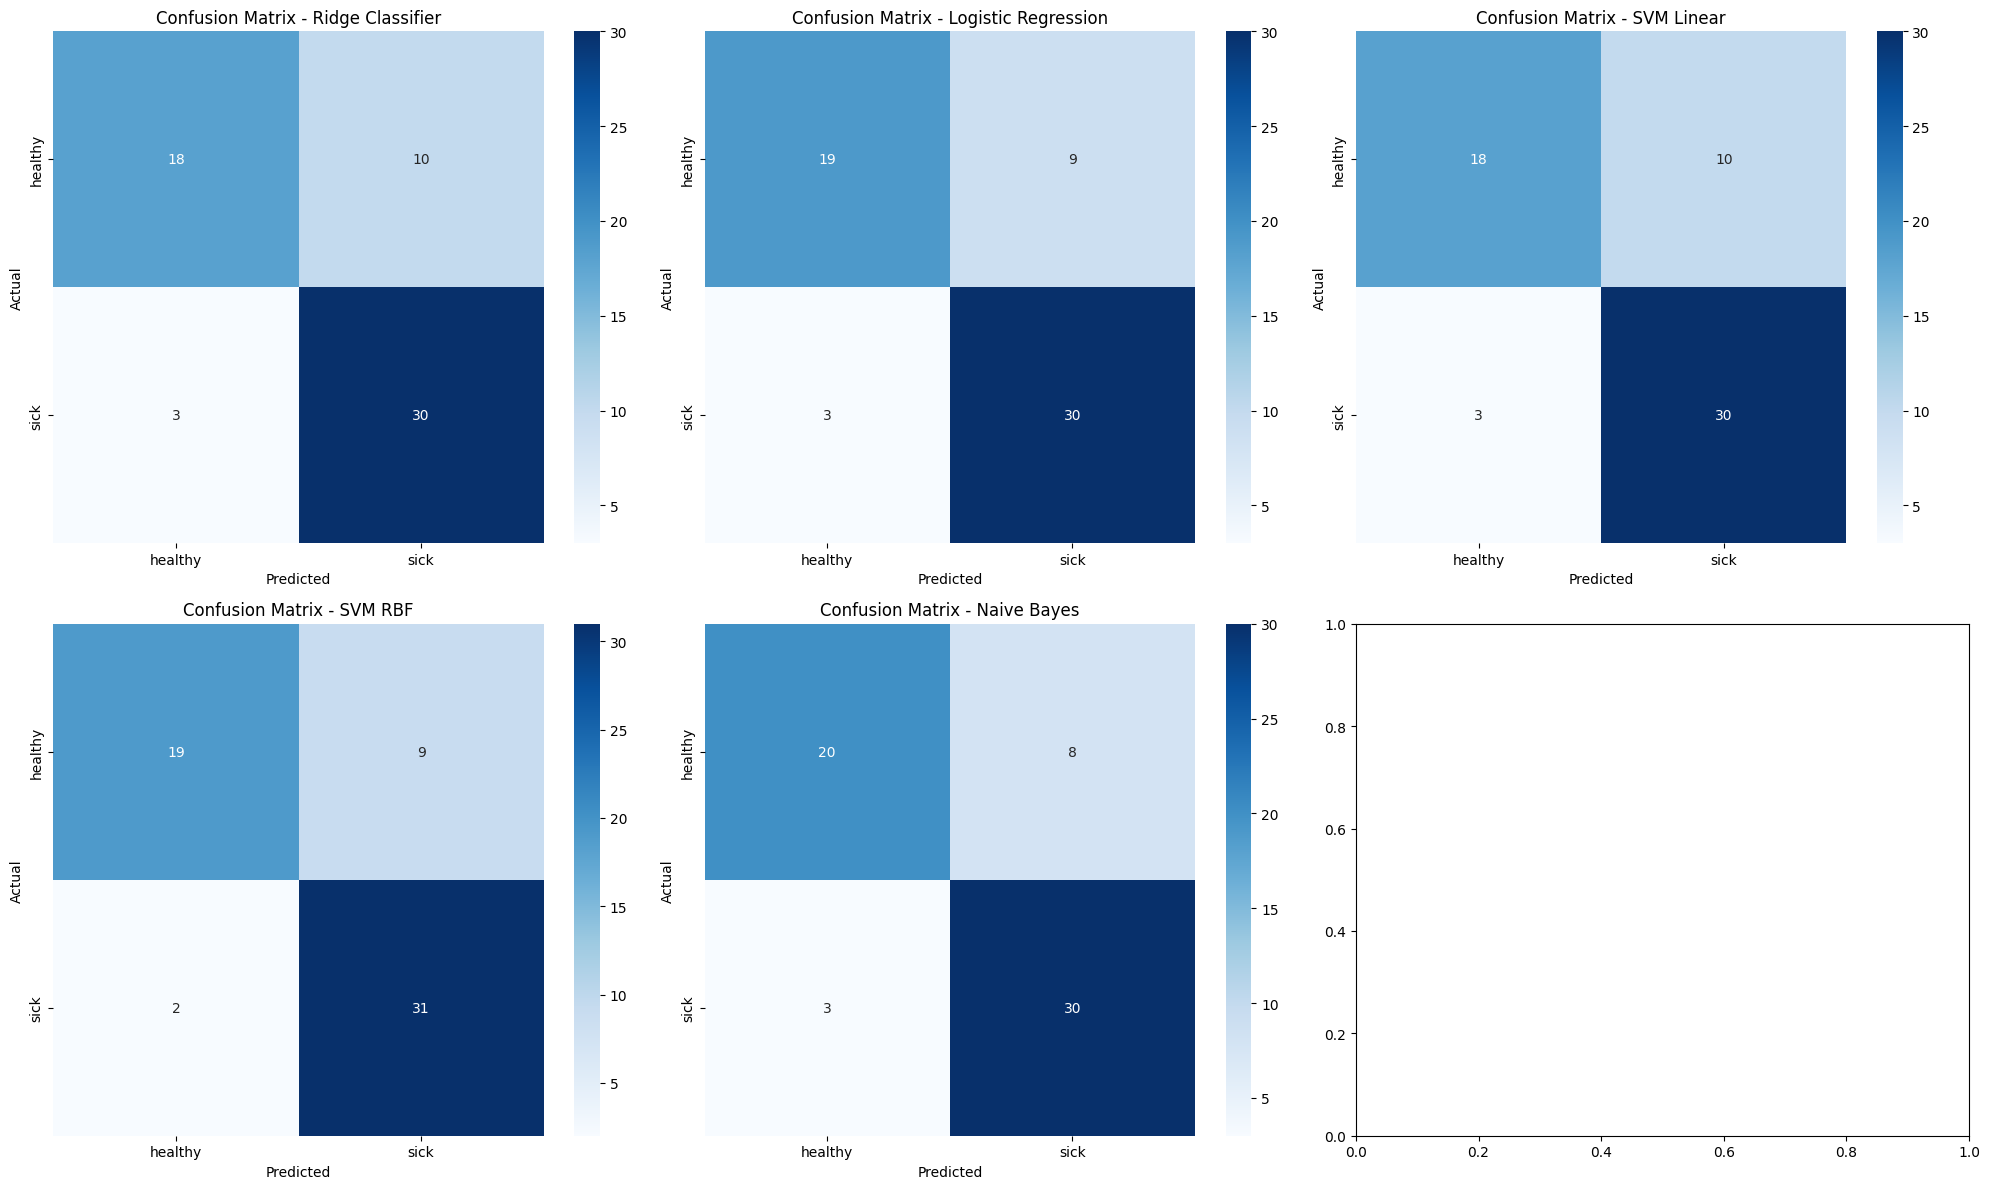

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

models = [('Ridge Classifier', y_pred_rid),
          ('Logistic Regression', y_pred_log), 
          ('SVM Linear', y_pred_svm_linear), 
          ('SVM RBF', y_pred_svm_rbf),
          ('Naive Bayes', y_pred_gaus_nb)]

for i, (name, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names, ax=axes[i // 3][i % 3])
    axes[i // 3][i % 3].set_title(f'Confusion Matrix - {name}')
    axes[i // 3][i % 3].set_xlabel('Predicted')
    axes[i // 3][i % 3].set_ylabel('Actual')

plt.tight_layout()
plt.show()

### Cross-валидация

In [46]:
cv_val = 10
print(f"Кросс-валидация ({cv_val} folds):")

cv_scores_rid = cross_val_score(rid_clf, X_train_scaled, y_train, cv=cv_val, scoring='accuracy')
cv_scores_log = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv_val, scoring='accuracy')
cv_scores_svm_linear = cross_val_score(svm_linear, X_train_scaled, y_train, cv=cv_val, scoring='accuracy')
cv_scores_svm_rbf = cross_val_score(svm_rbf, X_train_scaled, y_train, cv=cv_val, scoring='accuracy')
cv_scores_gaus_nb = cross_val_score(gaus_nb, X_train_scaled, y_train, cv=cv_val, scoring='accuracy')

print(f"Ridge Classifier CV Accuracy: {cv_scores_rid.mean():.4f} (±{(2 * cv_scores_rid.std() / np.sqrt(cv_val)):.4f})")
print(f"Logistic Regression CV Accuracy: {cv_scores_log.mean():.4f} (±{(2 * cv_scores_log.std() / np.sqrt(cv_val)):.4f})")
print(f"SVM Linear CV Accuracy: {cv_scores_svm_linear.mean():.4f} (±{(2 * cv_scores_svm_linear.std() / np.sqrt(cv_val)):.4f})")
print(f"SVM RBF CV Accuracy: {cv_scores_svm_rbf.mean():.4f} (±{(2 * cv_scores_svm_rbf.std() / np.sqrt(cv_val)):.4f})")
print(f"Naive Bayes CV Accuracy: {cv_scores_gaus_nb.mean():.4f} (±{(2 * cv_scores_gaus_nb.std() / np.sqrt(cv_val)):.4f})")

Кросс-валидация (10 folds):
Ridge Classifier CV Accuracy: 0.8352 (±0.0376)
Logistic Regression CV Accuracy: 0.8228 (±0.0338)
SVM Linear CV Accuracy: 0.8560 (±0.0395)
SVM RBF CV Accuracy: 0.8145 (±0.0525)
Naive Bayes CV Accuracy: 0.8058 (±0.0203)


### Коэффициенты и интерпретация

In [18]:
coef_results = pd.DataFrame({"ridge": rid_clf.coef_, "logreg": log_reg.coef_[0], "svm": svm_linear.coef_[0]}, index=feature_col)
coef_results

,ridge,logreg,svm
age,-0.005656,0.017736,0.017517
sex,-0.153400,-0.714030,-0.451142
cp,0.263012,0.937735,0.741343
trestbps,-0.037392,-0.211437,-0.189578
chol,-0.083818,-0.459210,-0.218996
fbs,-0.001415,-0.063649,0.046111
restecg,0.047901,0.235471,0.095748
thalach,0.127352,0.539629,0.302044
exang,-0.142976,-0.475883,-0.297806
oldpeak,-0.146808,-0.594819,-0.496127


In [19]:
coef_results["ridge"].sort_values(key=lambda x: abs(x), ascending=False)

cp          0.263012
thal       -0.169203
sex        -0.153400
ca         -0.151737
oldpeak    -0.146808
exang      -0.142976
thalach     0.127352
slope       0.094311
chol       -0.083818
restecg     0.047901
trestbps   -0.037392
age        -0.005656
fbs        -0.001415
Name: ridge, dtype: float64

In [20]:
coef_results["logreg"].sort_values(key=lambda x: abs(x), ascending=False)

cp          0.937735
sex        -0.714030
thal       -0.621578
oldpeak    -0.594819
ca         -0.559203
thalach     0.539629
exang      -0.475883
chol       -0.459210
slope       0.307867
restecg     0.235471
trestbps   -0.211437
fbs        -0.063649
age         0.017736
Name: logreg, dtype: float64

In [21]:
coef_results["svm"].sort_values(key=lambda x: abs(x), ascending=False)

cp          0.741343
thal       -0.499042
oldpeak    -0.496127
ca         -0.459259
sex        -0.451142
thalach     0.302044
exang      -0.297806
slope       0.292529
chol       -0.218996
trestbps   -0.189578
restecg     0.095748
fbs         0.046111
age         0.017517
Name: svm, dtype: float64

Для всех классификаторов наиболее влиятельным оказался признак `cp` - тип боли в груди (чем выше, тем вероятноее заболевание). Он сильнее всего влияет на то есть заболевание или нет. Интересно, что следующие четыре признака (`thal` - талассемия, `oldpeak` - депрессия ST сегмента, `ca` - количество основных сосудов, `sex` - пол) идут после `cp`, но в разных алгоритмах находятся на разных местах, хотя есть общее: они отрицательно влияют на заболеваемость. 

## Подбор гиперпараметров

В классификаторах выше есть только один гиперпараметр `C` - коэффициент регуляризации, поэтому будем подбирать его, используя cross-валидацию.

### Гребневый классификатор

In [22]:
param_grid_rid_simple = {
    'alpha': np.logspace(-3, 3, 15),
    'solver': ['svd']
}

grid_rid = GridSearchCV(
    RidgeClassifier(random_state=42, max_iter=10000),
    param_grid_rid_simple,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_rid.fit(X_train_scaled, y_train)

print(f"Лучшие параметры: {grid_rid.best_params_}")
print(f"Лучшая точность: {grid_rid.best_score_:.4f}")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Лучшие параметры: {'alpha': np.float64(0.001), 'solver': 'svd'}
Лучшая точность: 0.8310


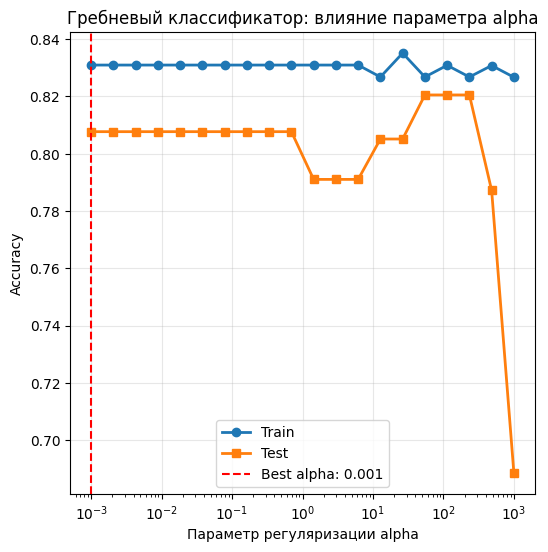

In [23]:
alpha_values = np.logspace(-3, 3, 20)
train_scores = []
test_scores = []

for C_val in alpha_values:
    model = RidgeClassifier(alpha=C_val, solver='svd', random_state=42)
    model.fit(X_train_scaled, y_train)

    train_score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    test_score = cross_val_score(model, X_test_scaled, y_test, cv=5, scoring='accuracy')
    
    train_scores.append(train_score.mean())
    test_scores.append(test_score.mean())

plt.figure(figsize=(6, 6))

plt.semilogx(alpha_values, train_scores, 'o-', label='Train', linewidth=2)
plt.semilogx(alpha_values, test_scores, 's-', label='Test', linewidth=2)
plt.axvline(grid_rid.best_params_['alpha'], color='red', linestyle='--', 
           label=f'Best alpha: {grid_rid.best_params_["alpha"]:.3f}')
plt.xlabel('Параметр регуляризации alpha')
plt.ylabel('Accuracy')
plt.title('Гребневый классификатор: влияние параметра alpha')
plt.legend()
plt.grid(True, alpha=0.3)

### Логистическая регрессия

In [24]:
param_grid_log_simple = {
    'C': np.logspace(-3, 3, 15),
    'penalty': ['l2', 'l1'],
    'solver': ['liblinear']
}

grid_log = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=10000),
    param_grid_log_simple,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_log.fit(X_train_scaled, y_train)

print(f"Лучшие параметры: {grid_log.best_params_}")
print(f"Лучшая точность: {grid_log.best_score_:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучшие параметры: {'C': np.float64(0.3727593720314938), 'penalty': 'l1', 'solver': 'liblinear'}
Лучшая точность: 0.8473


/home/unicornred/.local/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/unicornred/.local/lib/python3.13/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


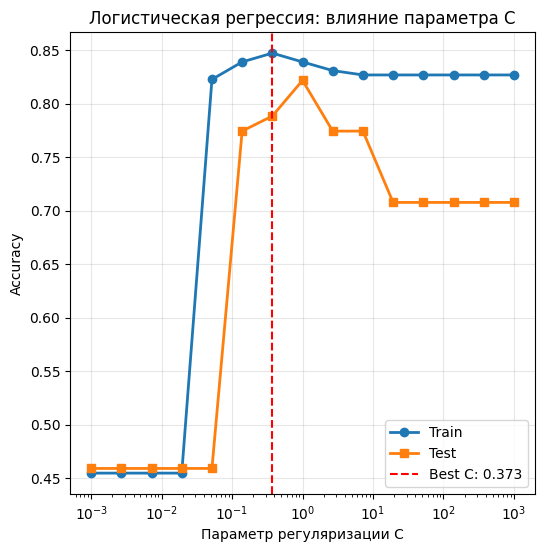

In [25]:
C_values = np.logspace(-3, 3, 15)
train_scores_log = []
test_scores_log = []

for C_val in C_values:
    model = LogisticRegression(C=C_val, penalty='l1', solver='liblinear', random_state=42)
    model.fit(X_train_scaled, y_train)

    train_score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    test_score = cross_val_score(model, X_test_scaled, y_test, cv=5, scoring='accuracy')
    
    train_scores_log.append(train_score.mean())
    test_scores_log.append(test_score.mean())

plt.figure(figsize=(6, 6))

plt.semilogx(C_values, train_scores_log, 'o-', label='Train', linewidth=2)
plt.semilogx(C_values, test_scores_log, 's-', label='Test', linewidth=2)
plt.axvline(grid_log.best_params_['C'], color='red', linestyle='--', 
           label=f'Best C: {grid_log.best_params_["C"]:.3f}')
plt.xlabel('Параметр регуляризации C')
plt.ylabel('Accuracy')
plt.title('Логистическая регрессия: влияние параметра C')
plt.legend()
plt.grid(True, alpha=0.3)

### Зависимость от типа регуляризации

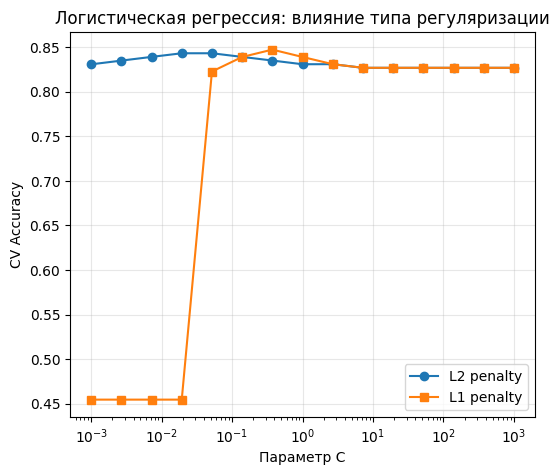

In [26]:
results_log = pd.DataFrame(grid_log.cv_results_)
plt.figure(figsize=(6, 5))
plt.semilogx(results_log[results_log['param_penalty'] == 'l2']['param_C'], 
            results_log[results_log['param_penalty'] == 'l2']['mean_test_score'], 
            'o-', label='L2 penalty')
plt.semilogx(results_log[results_log['param_penalty'] == 'l1']['param_C'], 
            results_log[results_log['param_penalty'] == 'l1']['mean_test_score'], 
            's-', label='L1 penalty')
plt.xlabel('Параметр C')
plt.ylabel('CV Accuracy')
plt.title('Логистическая регрессия: влияние типа регуляризации')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Сравнение с и без регуляризации

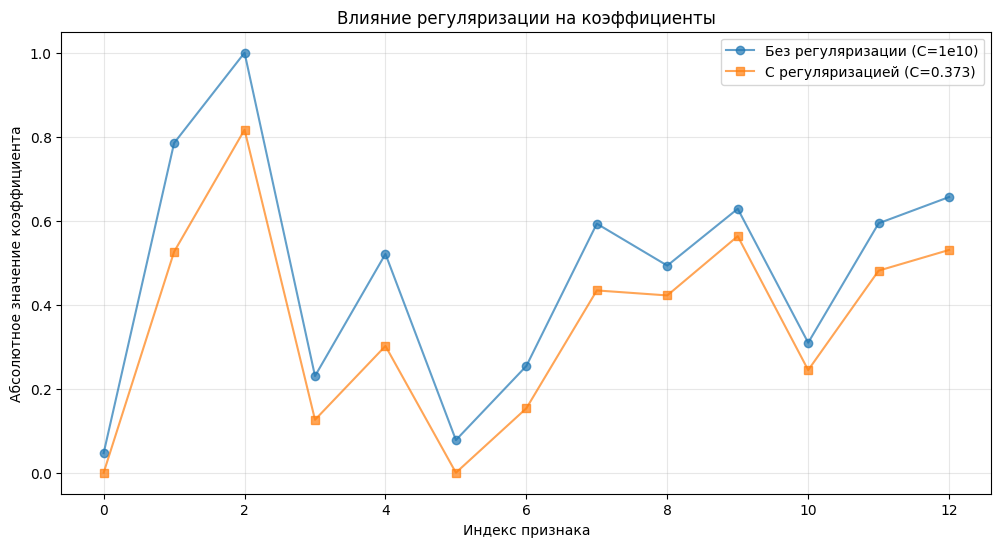


Норма коэффициентов без регуляризации: 1.970
Норма коэффициентов с регуляризацией: 1.526


In [27]:
log_reg_no_reg = LogisticRegression(C=1e10, random_state=42)
log_reg_no_reg.fit(X_train_scaled, y_train)

coef_no_reg = np.abs(log_reg_no_reg.coef_[0])
coef_reg = np.abs(grid_log.best_estimator_.coef_[0])

plt.figure(figsize=(12, 6))
plt.plot(coef_no_reg, 'o-', alpha=0.7, label='Без регуляризации (C=1e10)')
plt.plot(coef_reg, 's-', alpha=0.7, label=f'С регуляризацией (C={grid_log.best_params_["C"]:.3f})')
plt.xlabel('Индекс признака')
plt.ylabel('Абсолютное значение коэффициента')
plt.title('Влияние регуляризации на коэффициенты')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nНорма коэффициентов без регуляризации: {np.linalg.norm(coef_no_reg):.3f}")
print(f"Норма коэффициентов с регуляризацией: {np.linalg.norm(coef_reg):.3f}")

### SVM

In [28]:
param_grid_svm_simple = {
    'C': np.logspace(-2, 2, 10),
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid_svm_simple,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_svm.fit(X_train_scaled, y_train)

print(f"Лучшие параметры: {grid_svm.best_params_}")
print(f"Лучшая точность: {grid_svm.best_score_:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Лучшие параметры: {'C': np.float64(0.21544346900318834), 'gamma': 'scale', 'kernel': 'linear'}
Лучшая точность: 0.8556


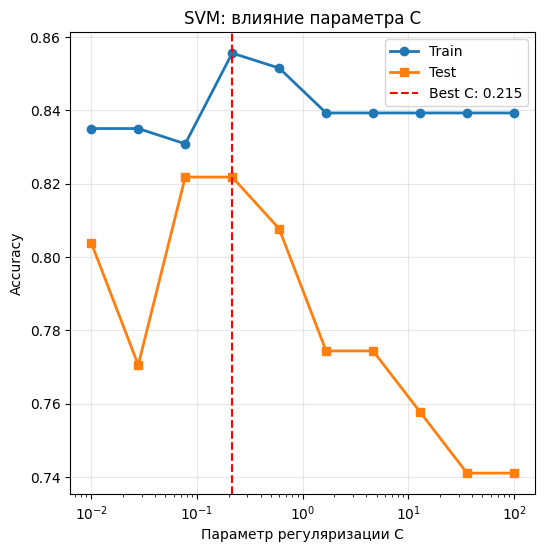

In [29]:
C_values = np.logspace(-2, 2, 10)
train_scores_svm = []
test_scores_svm = []

for C_val in C_values:
    model = SVC(C=C_val, kernel='linear', gamma='scale', random_state=42)
    model.fit(X_train_scaled, y_train)
    
    train_score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    test_score = cross_val_score(model, X_test_scaled, y_test, cv=5, scoring='accuracy')
    
    train_scores_svm.append(train_score.mean())
    test_scores_svm.append(test_score.mean())

plt.figure(figsize=(6, 6))

plt.semilogx(C_values, train_scores_svm, 'o-', label='Train', linewidth=2)
plt.semilogx(C_values, test_scores_svm, 's-', label='Test', linewidth=2)
plt.axvline(grid_svm.best_params_['C'], color='red', linestyle='--', 
           label=f'Best C: {grid_svm.best_params_["C"]:.3f}')
plt.xlabel('Параметр регуляризации C')
plt.ylabel('Accuracy')
plt.title('SVM: влияние параметра C')
plt.legend()
plt.grid(True, alpha=0.3)

### Влияние типа ядра

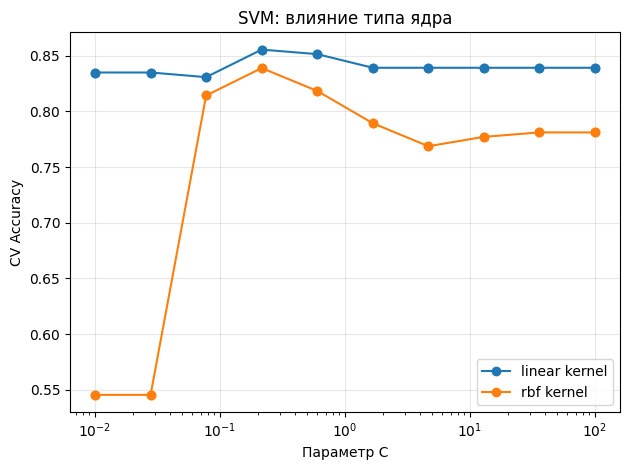

In [30]:
results_svm = pd.DataFrame(grid_svm.cv_results_)

for kernel in results_svm['param_kernel'].unique():
    kernel_data = results_svm[results_svm['param_kernel'] == kernel]
    plt.semilogx(kernel_data['param_C'], kernel_data['mean_test_score'], 
                'o-', label=f'{kernel} kernel')
plt.xlabel('Параметр C')
plt.ylabel('CV Accuracy')
plt.title('SVM: влияние типа ядра')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Обучение лучших моделей

In [31]:
best_rid = grid_rid.best_estimator_
best_y_pred_rid = best_rid.predict(X_test_scaled)

best_log_reg = grid_log.best_estimator_
best_y_pred_log = best_log_reg.predict(X_test_scaled)
best_y_proba_log = best_log_reg.predict_proba(X_test_scaled)[:, 1]

best_svm = grid_svm.best_estimator_
best_y_pred_svm = best_svm.predict(X_test_scaled)
best_y_proba_svm = best_svm.predict_proba(X_test_scaled)[:, 1]

### Cross-валидация результатов на тренировочном наборе

In [47]:
cv_val = 10
best_cv_scores_rid = cross_val_score(best_rid, X_train_scaled, y_train, 
                               cv=cv_val, scoring='accuracy')
best_cv_scores_log = cross_val_score(best_log_reg, X_train_scaled, y_train, 
                               cv=cv_val, scoring='accuracy')
best_cv_scores_svm = cross_val_score(best_svm, X_train_scaled, y_train, 
                               cv=cv_val, scoring='accuracy')

print(f"Гребневый классификатор CV Accuracy: {cv_scores_rid.mean():.4f} (±{(2 * cv_scores_rid.std() / np.sqrt(cv_val)):.4f})")
print(f"Логистическая регрессия CV Accuracy: {cv_scores_log.mean():.4f} (±{(2 * cv_scores_log.std() / np.sqrt(cv_val)):.4f})")
print(f"SVM CV Accuracy: {cv_scores_svm_linear.mean():.4f} (±{(2 * cv_scores_svm_linear.std() / np.sqrt(cv_val)):.4f})")
print(f"Гребневый классификатор CV Accuracy (лучшая): {best_cv_scores_rid.mean():.4f} (±{(2 * best_cv_scores_rid.std() / np.sqrt(cv_val)):.4f})")
print(f"Логистическая регрессия CV Accuracy (лучшая): {best_cv_scores_log.mean():.4f} (±{(2 * best_cv_scores_log.std() / np.sqrt(cv_val)):.4f})")
print(f"SVM CV Accuracy (лучшая): {best_cv_scores_svm.mean():.4f} (±{(2 * best_cv_scores_svm.std() / np.sqrt(cv_val)):.4f})")

Гребневый классификатор CV Accuracy: 0.8352 (±0.0376)
Логистическая регрессия CV Accuracy: 0.8228 (±0.0338)
SVM CV Accuracy: 0.8560 (±0.0395)
Гребневый классификатор CV Accuracy (лучшая): 0.8352 (±0.0376)
Логистическая регрессия CV Accuracy (лучшая): 0.8310 (±0.0309)
SVM CV Accuracy (лучшая): 0.8475 (±0.0377)


### Метрики на тестовом наборе

In [33]:
best_metrics_rid = evaluate_model(y_test, best_y_pred_rid, None, 
                           f"Гребневый классификатор (alpha={grid_rid.best_params_['alpha']:.3f})")

best_metrics_log = evaluate_model(y_test, best_y_pred_log, y_proba_log, 
                           f"Логистическая регрессия (C={grid_log.best_params_['C']:.3f})")

best_metrics_svm = evaluate_model(y_test, best_y_pred_svm, best_y_proba_svm, 
                           f"SVM (C={grid_svm.best_params_['C']}, kernel={grid_svm.best_params_['kernel']})")


Гребневый классификатор (alpha=0.001):
Accuracy: 0.7869
Precision: 0.7500
Recall: 0.9091
F1-Score: 0.8219
ROC AUC: 0.0000

Classification Report:
              precision    recall  f1-score   support

     healthy       0.86      0.64      0.73        28
        sick       0.75      0.91      0.82        33

    accuracy                           0.79        61
   macro avg       0.80      0.78      0.78        61
weighted avg       0.80      0.79      0.78        61


Логистическая регрессия (C=0.373):
Accuracy: 0.8033
Precision: 0.7692
Recall: 0.9091
F1-Score: 0.8333
ROC AUC: 0.8690

Classification Report:
              precision    recall  f1-score   support

     healthy       0.86      0.68      0.76        28
        sick       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61


SVM (C=0.21544346900318834, kernel=linear):
Accuracy: 0

### Сравнение метрик до и после подбора

In [34]:
print("Accuracy для гребневого классификатора:", metrics_rid["Accuracy"], "->", best_metrics_rid["Accuracy"])
print("Accuracy для логистической регрессии:", metrics_log["Accuracy"], "->", best_metrics_log["Accuracy"])
print("Accuracy для линейного SVM:", metrics_svm_linear["Accuracy"], "->", best_metrics_svm["Accuracy"])
print()
print("Precision для гребневого классификатора:", metrics_rid["Precision"], "->", best_metrics_rid["Precision"])
print("Precision для логистической регрессии:", metrics_log["Precision"], "->", best_metrics_log["Precision"])
print("Precision для линейного SVM:", metrics_svm_linear["Precision"], "->", best_metrics_svm["Precision"])
print()
print("Recall для гребневого классификатора:", metrics_rid["Recall"], "->", best_metrics_rid["Recall"])
print("Recall для логистической регрессии:", metrics_log["Recall"], "->", best_metrics_log["Recall"])
print("Recall для линейного SVM:", metrics_svm_linear["Recall"], "->", best_metrics_svm["Recall"])
print()
print("F1-Score для гребневого классификатора:", metrics_rid["F1-Score"], "->", best_metrics_rid["F1-Score"])
print("F1-Score для логистической регрессии:", metrics_log["F1-Score"], "->", best_metrics_log["F1-Score"])
print("F1-Score для линейного SVM:", metrics_svm_linear["F1-Score"], "->", best_metrics_svm["F1-Score"])
print()
print("ROC AUC для логистической регрессии:", metrics_log["ROC AUC"], "->", best_metrics_log["ROC AUC"])
print("ROC AUC для линейного SVM:", metrics_svm_linear["ROC AUC"], "->", best_metrics_svm["ROC AUC"])

Accuracy для гребневого классификатора: 0.7868852459016393 -> 0.7868852459016393
Accuracy для логистической регрессии: 0.8032786885245902 -> 0.8032786885245902
Accuracy для линейного SVM: 0.7868852459016393 -> 0.819672131147541

Precision для гребневого классификатора: 0.75 -> 0.75
Precision для логистической регрессии: 0.7692307692307693 -> 0.7692307692307693
Precision для линейного SVM: 0.75 -> 0.7619047619047619

Recall для гребневого классификатора: 0.9090909090909091 -> 0.9090909090909091
Recall для логистической регрессии: 0.9090909090909091 -> 0.9090909090909091
Recall для линейного SVM: 0.9090909090909091 -> 0.9696969696969697

F1-Score для гребневого классификатора: 0.821917808219178 -> 0.821917808219178
F1-Score для логистической регрессии: 0.8333333333333334 -> 0.8333333333333334
F1-Score для линейного SVM: 0.821917808219178 -> 0.8533333333333334

ROC AUC для логистической регрессии: 0.8690476190476191 -> 0.8690476190476191
ROC AUC для линейного SVM: 0.8841991341991342 -> 0.

### Коэффициенты после подбора

In [35]:
best_coef_results = pd.DataFrame({"ridge": best_rid.coef_, "logreg": best_log_reg.coef_[0], "svm": best_svm.coef_[0]}, index=feature_col)
best_coef_results

,ridge,logreg,svm
age,-0.005276,0.000000,0.051236
sex,-0.153901,-0.525974,-0.369843
cp,0.263855,0.816488,0.649794
trestbps,-0.037513,-0.126027,-0.199998
chol,-0.084196,-0.301696,-0.204742
fbs,-0.001436,0.000000,0.009280
restecg,0.047942,0.153389,0.058700
thalach,0.127618,0.433916,0.337859
exang,-0.142939,-0.422027,-0.309078
oldpeak,-0.147074,-0.563041,-0.434600


In [36]:
best_coef_results["ridge"].sort_values(key=lambda x: abs(x), ascending=False)

cp          0.263855
thal       -0.169515
sex        -0.153901
ca         -0.152048
oldpeak    -0.147074
exang      -0.142939
thalach     0.127618
slope       0.094214
chol       -0.084196
restecg     0.047942
trestbps   -0.037513
age        -0.005276
fbs        -0.001436
Name: ridge, dtype: float64

In [37]:
best_coef_results["logreg"].sort_values(key=lambda x: abs(x), ascending=False)

cp          0.816488
oldpeak    -0.563041
thal       -0.530287
sex        -0.525974
ca         -0.481016
thalach     0.433916
exang      -0.422027
chol       -0.301696
slope       0.244334
restecg     0.153389
trestbps   -0.126027
age         0.000000
fbs         0.000000
Name: logreg, dtype: float64

In [38]:
best_coef_results["svm"].sort_values(key=lambda x: abs(x), ascending=False)

cp          0.649794
thal       -0.451663
oldpeak    -0.434600
ca         -0.400484
sex        -0.369843
thalach     0.337859
exang      -0.309078
slope       0.246632
chol       -0.204742
trestbps   -0.199998
restecg     0.058700
age         0.051236
fbs         0.009280
Name: svm, dtype: float64

Коэффициенты практически такие же.

## Визуализация разделяющей гиперплоскости

Будем использовать только два признака (чтобы было удобнее визуализировать), а именно: самый влиятельный `cp` и `oldpeak` (топ-5 и имеет количественную природу).

In [39]:
two_features = [7, 9]
X_train_log_2d = X_train_scaled[:, two_features]
X_test_log_2d= X_test_scaled[:, two_features]

# Обучаем модели на 2D данных
log_reg_2d = LogisticRegression(random_state=42)
log_reg_2d.fit(X_train_log_2d, y_train)

X_train_svm_2d = X_train_scaled[:, two_features]
X_test_svm_2d= X_test_scaled[:, two_features]

svm_linear_2d = SVC(kernel='linear', random_state=42)
svm_linear_2d.fit(X_train_svm_2d, y_train)

svm_rbf_2d = SVC(kernel='rbf', random_state=42)
svm_rbf_2d.fit(X_train_svm_2d, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


### Визуализируем логистическую регрессию

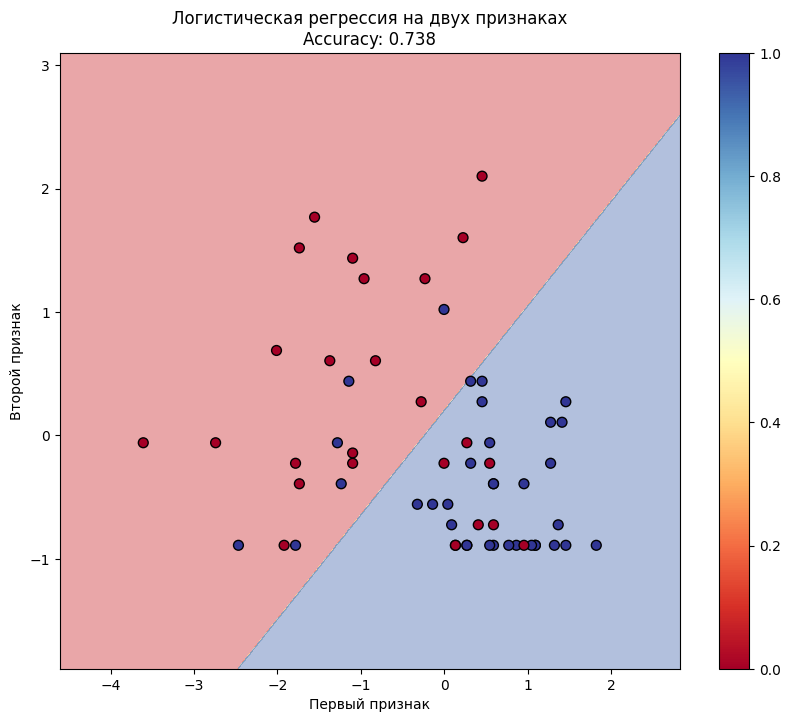

Логистическая регрессия на двух признаках:
Уравнение гиперплоскости: 0.735*x1 + -0.868*x2 + 0.178 = 0
Нормаль к гиперплоскости: [0.735, -0.868]


In [40]:
# Функция для визуализации решающих границ
def plot_decision_boundary(model, X, y, title):
    # Создаем сетку для визуализации
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    
    # Предсказания для сетки
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k', cmap='RdYlBu')
    plt.title(f'{title}\nAccuracy: {accuracy_score(y, model.predict(X)):.3f}')
    plt.xlabel('Первый признак')
    plt.ylabel('Второй признак')
    plt.colorbar()
    plt.show()
    
    # Вывод информации о модели
    if hasattr(model, 'coef_'):
        print(f"{title}:")
        print(f"Уравнение гиперплоскости: {model.coef_[0][0]:.3f}*x1 + {model.coef_[0][1]:.3f}*x2 + {model.intercept_[0]:.3f} = 0")
        print(f"Нормаль к гиперплоскости: [{model.coef_[0][0]:.3f}, {model.coef_[0][1]:.3f}]")

# Визуализация для разных моделей
plot_decision_boundary(log_reg_2d, X_test_log_2d, y_test, "Логистическая регрессия на двух признаках")

### Визуализируем SVM (с линейным и нелинейным ядром)

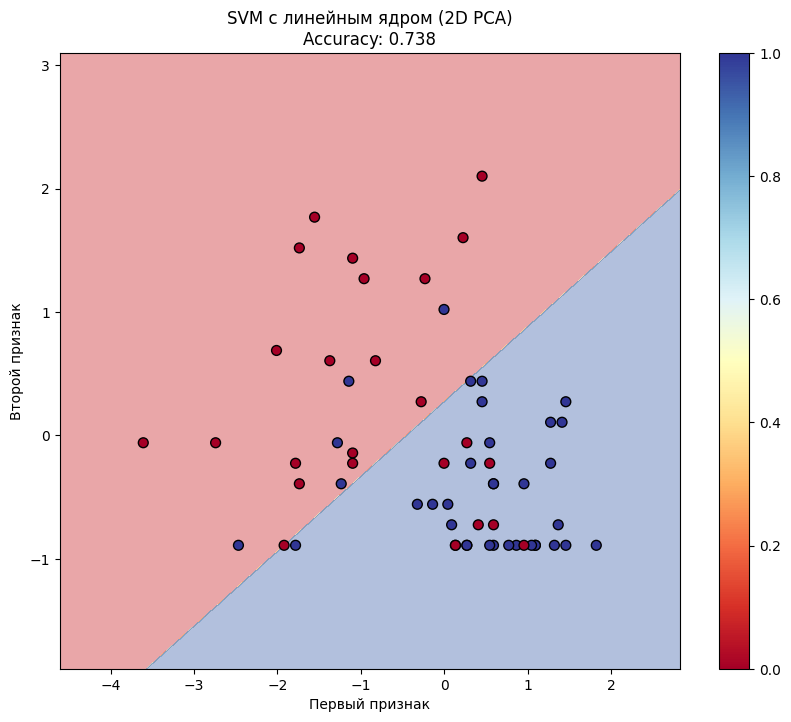

SVM с линейным ядром (2D PCA):
Уравнение гиперплоскости: 0.477*x1 + -0.785*x2 + 0.217 = 0
Нормаль к гиперплоскости: [0.477, -0.785]


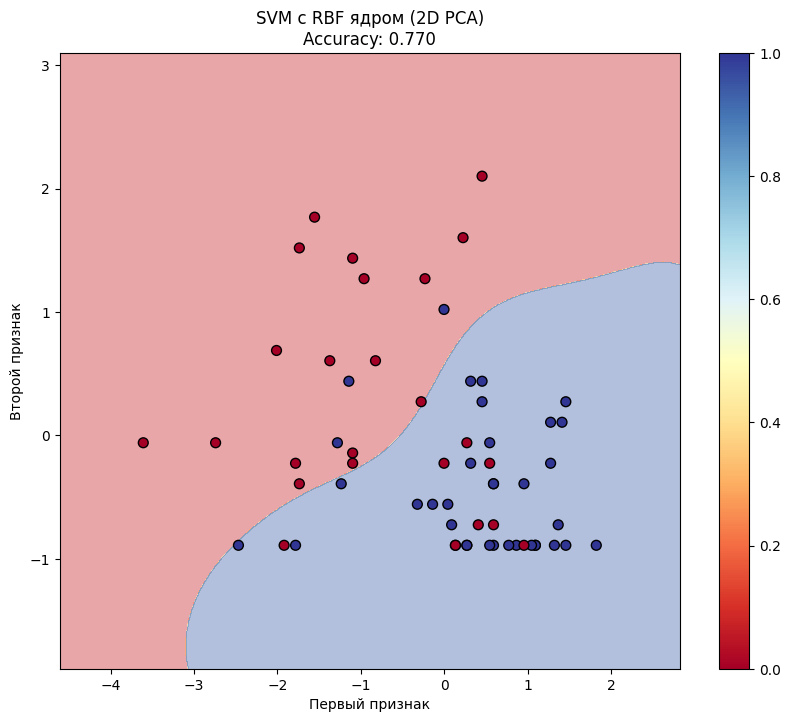

In [41]:
plot_decision_boundary(svm_linear_2d, X_test_svm_2d, y_test, "SVM с линейным ядром (2D PCA)")
plot_decision_boundary(svm_rbf_2d, X_test_svm_2d, y_test, "SVM с RBF ядром (2D PCA)")

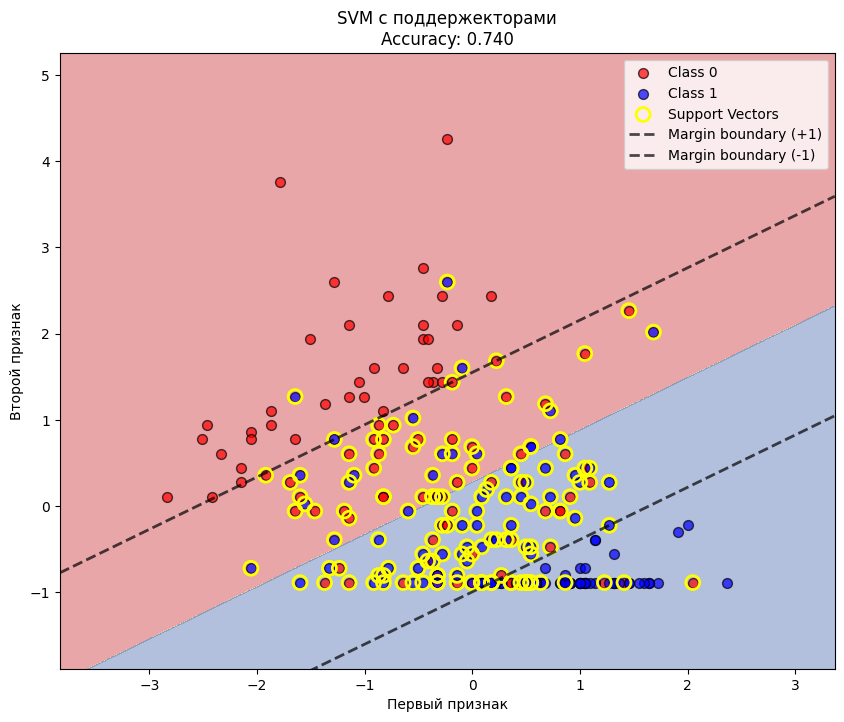

In [42]:
# Визуализация с поддержекторами для SVM
def plot_svm_decision_boundary(model, X, y, title):
    # Создаем сетку
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    
    # Предсказания для сетки
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Визуализация с поддержекторами
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
    
    # Разные маркеры для разных классов
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', s=50, edgecolor='k', 
                label='Class 0', alpha=0.7)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', s=50, edgecolor='k', 
                label='Class 1', alpha=0.7)
    
    # Подсветка поддержекторов
    if hasattr(model, 'support_vectors_'):
        support_vectors = model.support_vectors_
        plt.scatter(support_vectors[:, 0], support_vectors[:, 1], 
                   s=100, facecolors='none', edgecolors='yellow', 
                   linewidths=2, label='Support Vectors')
        
    if model.kernel == 'linear':
        w = model.coef_[0]
        b = model.intercept_[0]
        
        # Уравнение разделяющей гиперплоскости: w·x + b = 0
        # Маргинальные гиперплоскости: w·x + b = ±1
        
        # Находим точки на границах зазора
        x_plot = np.linspace(x_min, x_max, 100)
        y_plot_upper = (-w[0] * x_plot - b + 1) / w[1]
        y_plot_lower = (-w[0] * x_plot - b - 1) / w[1]
        
        plt.plot(x_plot, y_plot_upper, 'k--', alpha=0.7, linewidth=2, label='Margin boundary (+1)')
        plt.plot(x_plot, y_plot_lower, 'k--', alpha=0.7, linewidth=2, label='Margin boundary (-1)')
    
    plt.ylim((y_min, y_max))
    plt.title(f'{title}\nAccuracy: {accuracy_score(y, model.predict(X)):.3f}')
    plt.xlabel('Первый признак')
    plt.ylabel('Второй признак')
    plt.legend()
    plt.show()

plot_svm_decision_boundary(svm_linear_2d, X_train_svm_2d, y_train, "SVM с поддержекторами")

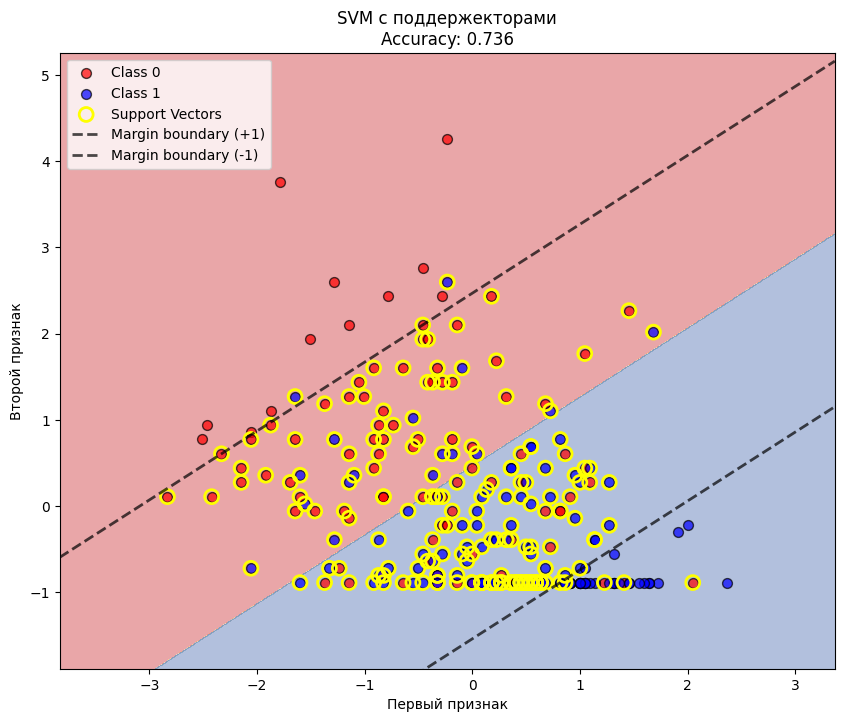

In [43]:
svm_linear_2d_C_001 = SVC(kernel='linear', random_state=42, C=1e-2)
svm_linear_2d_C_001.fit(X_train_svm_2d, y_train)

plot_svm_decision_boundary(svm_linear_2d_C_001, X_train_svm_2d, y_train, "SVM с поддержекторами")

### Синтетический пример про поддержки

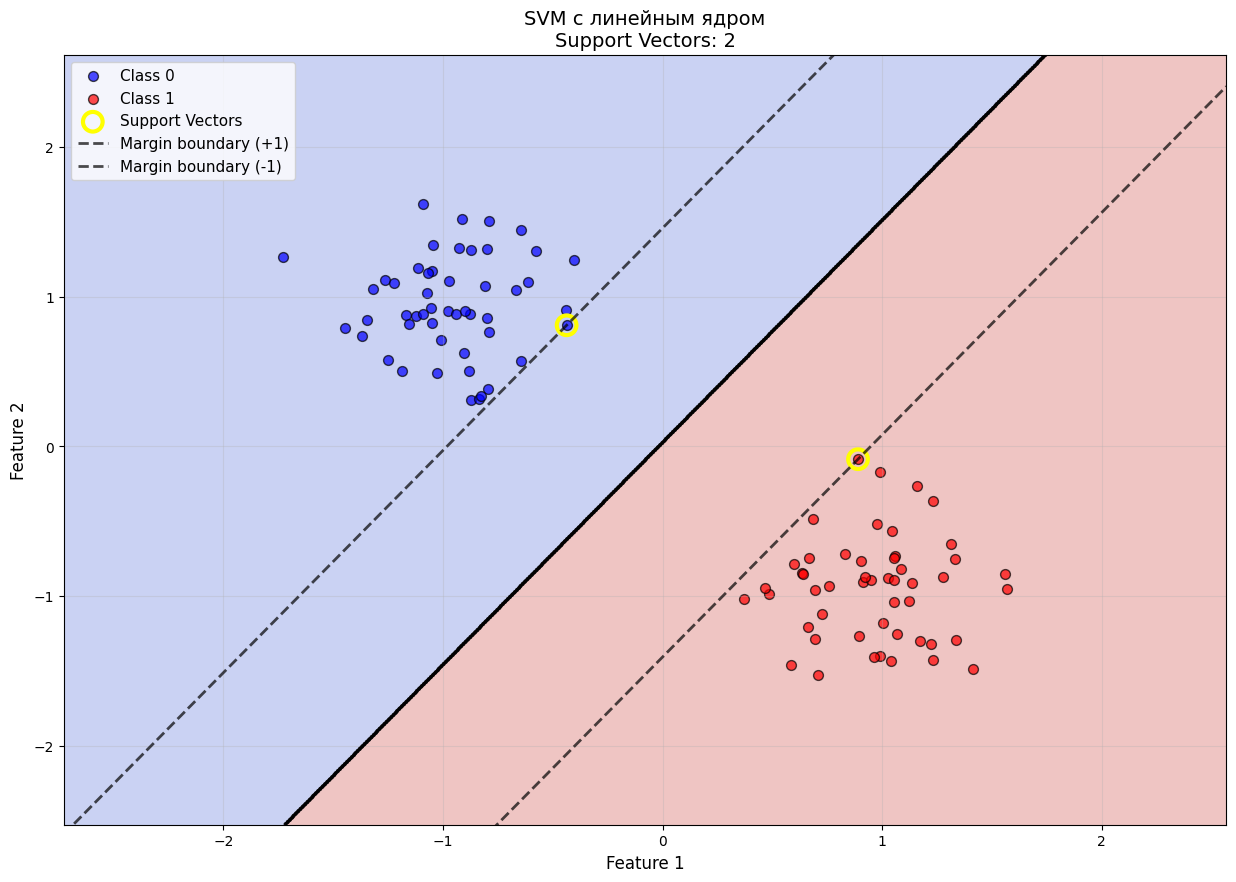

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Создадим простой synthetic dataset для наглядности
X, y = make_blobs(n_samples=100, centers=2, random_state=42, cluster_std=1.2)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучаем SVM
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_scaled, y)

# Функция для визуализации с объяснениями
def plot_svm_with_explanation(X, y, model, title):
    plt.figure(figsize=(15, 10))
    
    # Создаем сетку для визуализации
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                         np.linspace(y_min, y_max, 1000))
    
    # Предсказания для сетки
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # 1. Визуализация разделяющей гиперплоскости и зазора
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.contour(xx, yy, Z, colors='black', linewidths=2, alpha=0.5)
    
    # 2. Обычные точки данных
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', s=50, 
                edgecolor='k', alpha=0.7, label='Class 0')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', s=50, 
                edgecolor='k', alpha=0.7, label='Class 1')
    
    # 3. ПОДДЕРЖЕКТОРЫ - самые важные точки!
    support_vectors = model.support_vectors_
    plt.scatter(support_vectors[:, 0], support_vectors[:, 1], 
                s=200, facecolors='none', edgecolors='yellow',
                linewidths=3, label='Support Vectors')
    
    # 4. Маргинальные гиперплоскости
    # Для линейного ядра можем вычислить границы зазора
    if model.kernel == 'linear':
        w = model.coef_[0]
        b = model.intercept_[0]
        
        # Уравнение разделяющей гиперплоскости: w·x + b = 0
        # Маргинальные гиперплоскости: w·x + b = ±1
        
        # Находим точки на границах зазора
        x_plot = np.linspace(x_min, x_max, 100)
        y_plot_upper = (-w[0] * x_plot - b + 1) / w[1]
        y_plot_lower = (-w[0] * x_plot - b - 1) / w[1]
        
        plt.plot(x_plot, y_plot_upper, 'k--', alpha=0.7, linewidth=2, label='Margin boundary (+1)')
        plt.plot(x_plot, y_plot_lower, 'k--', alpha=0.7, linewidth=2, label='Margin boundary (-1)')
    
    plt.ylim((y_min, y_max))
    plt.title(f'{title}\nSupport Vectors: {len(support_vectors)}', fontsize=14)
    plt.xlabel('Feature 1', fontsize=12)
    plt.ylabel('Feature 2', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return support_vectors

# Визуализируем с объяснениями
support_vectors = plot_svm_with_explanation(X_scaled, y, svm, "SVM с линейным ядром")

### Более удачный в разделительном плане пример

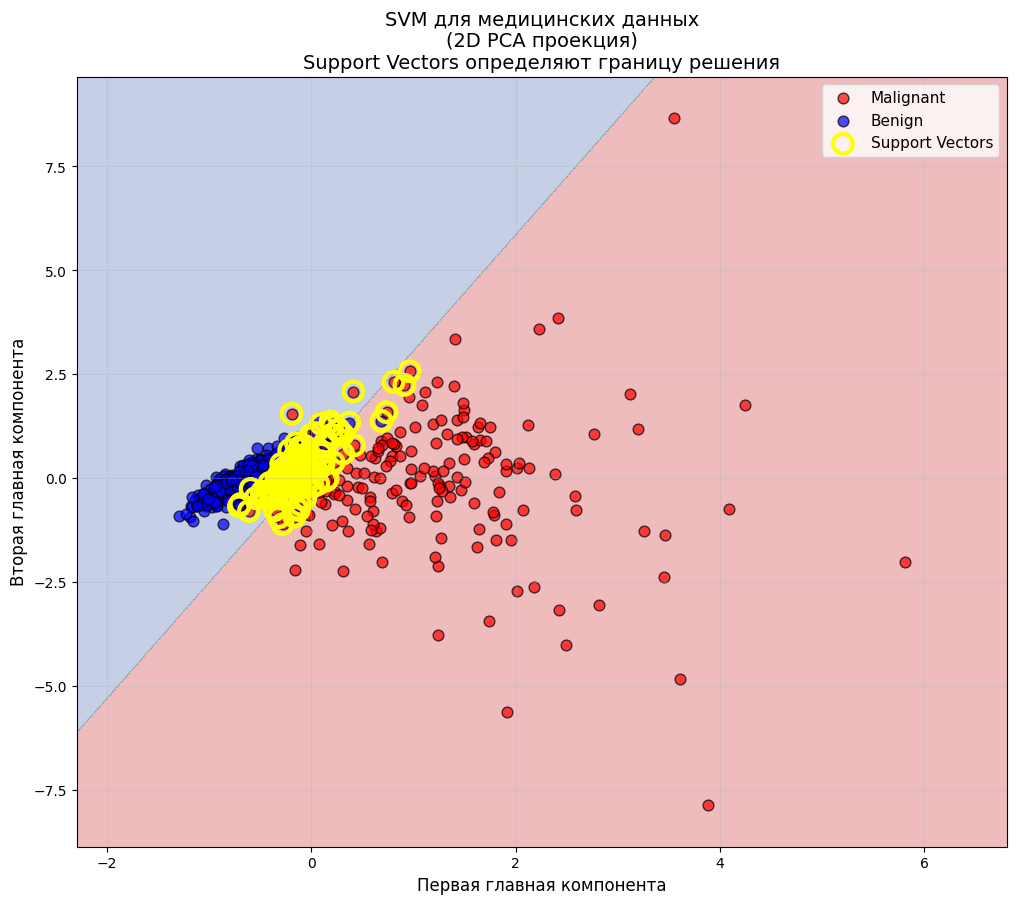

ПРАКТИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ:
1. ЖЕЛТЫЕ КРУГИ - это поддержекторы: самые 'сложные' случаи
2. Эти пациенты находятся на границе между классами
3. Их характеристики определяют, где проходит граница диагноза
4. Если новый пациент похож на эти 'пограничные' случаи - диагноз сложный
5. Пациенты внутри классов (не на границе) - типичные случаи


In [45]:
# Вернемся к нашему медицинскому датасету
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA

data = load_breast_cancer()
X, y = data.data, data.target

# Упростим до 2D для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

scaler = StandardScaler()
X_pca_scaled = scaler.fit_transform(X_pca)

# Обучаем SVM
svm_medical = SVC(kernel='linear', C=1.0, random_state=42)
svm_medical.fit(X_pca_scaled, y)

# Визуализация
plt.figure(figsize=(12, 10))

# Базовый график
x_min, x_max = X_pca_scaled[:, 0].min() - 1, X_pca_scaled[:, 0].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000),
                     np.linspace(X_pca_scaled[:, 1].min() - 1, X_pca_scaled[:, 1].max() + 1, 1000))

Z = svm_medical.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')

# Точки данных
plt.scatter(X_pca_scaled[y == 0, 0], X_pca_scaled[y == 0, 1], 
            c='red', s=60, alpha=0.7, label='Malignant', edgecolor='k')
plt.scatter(X_pca_scaled[y == 1, 0], X_pca_scaled[y == 1, 1], 
            c='blue', s=60, alpha=0.7, label='Benign', edgecolor='k')

# Поддержекторы
support_vectors = svm_medical.support_vectors_
plt.scatter(support_vectors[:, 0], support_vectors[:, 1],
            s=200, facecolors='none', edgecolors='yellow',
            linewidth=3, label='Support Vectors')

plt.title('SVM для медицинских данных\n(2D PCA проекция)\nSupport Vectors определяют границу решения', fontsize=14)
plt.xlabel('Первая главная компонента', fontsize=12)
plt.ylabel('Вторая главная компонента', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("ПРАКТИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ:")
print("1. ЖЕЛТЫЕ КРУГИ - это поддержекторы: самые 'сложные' случаи")
print("2. Эти пациенты находятся на границе между классами")
print("3. Их характеристики определяют, где проходит граница диагноза")
print("4. Если новый пациент похож на эти 'пограничные' случаи - диагноз сложный")
print("5. Пациенты внутри классов (не на границе) - типичные случаи")